In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import rqfactor
import talib
from rqalpha.apis import *
from rqfactor.notebook.exposure import factor_analysis
from rqoptimizer import *
from rqoptimizer.utils import *
from rqdatac import *
from rqalpha_plus import run_func
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from functools import wraps
warnings.filterwarnings("ignore")
rqdatac.init()

In [13]:
df_etf = pd.read_excel('../../ETF0-ML/etf标的.xlsx')
etf_code = df_etf.code.values.tolist()
etf_code = [str(code) for code in etf_code]
df_etf = all_instruments(type='ETF' , market = 'cn')
df_etf = df_etf[df_etf.trading_code.isin(etf_code)]

In [18]:
start = "2019-01-01"
end = "2023-12-31"
frequency = "1d"

In [19]:
etf_1 = ['515790','512480','512010','512980','159619','159766','512400','159930']
df_etf = all_instruments(type='ETF' , market = 'cn')
df_etf = df_etf[df_etf.trading_code.isin(etf_1)]
etf_1 = df_etf.order_book_id.values.tolist()

In [20]:
df_price_entry = get_price(etf_1, start, end, frequency)[['close']].unstack(level = 0)
df_price_entry.columns = df_price_entry.columns.droplevel(0)
frequency_h = '60m'
df_price_exit = get_price(etf_1, start, end, frequency_h)[['close']].unstack(level = 0)
df_price_exit.columns = df_price_exit.columns.droplevel(0)

<Axes: xlabel='datetime'>

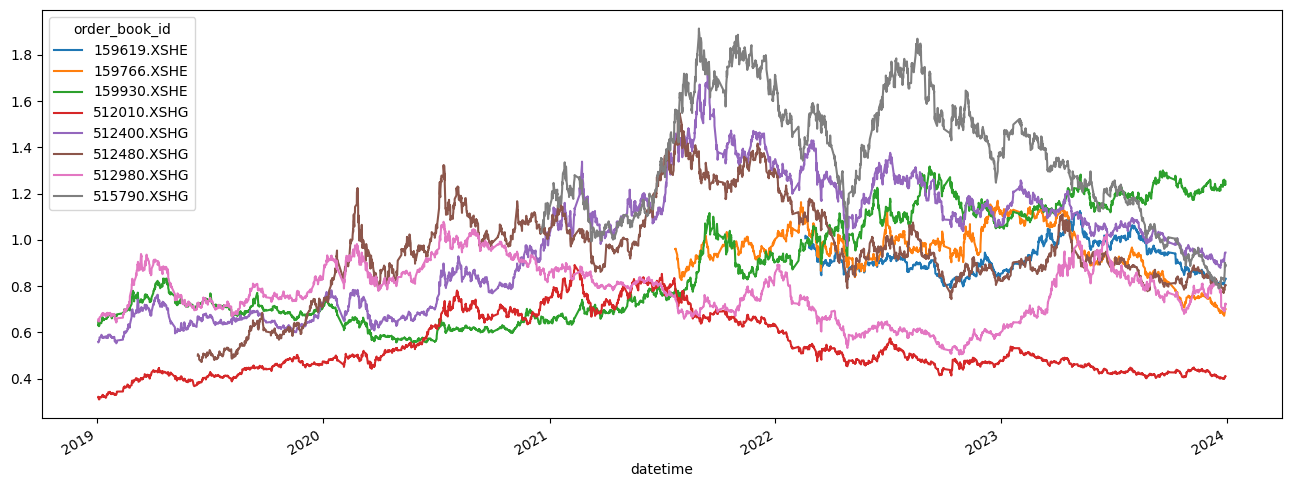

In [21]:
df_price_exit.plot(figsize = (16,6))

2014-07-14 00:00:00: 买入 159930.XSHE, 价格 0.78, 数量 6400
2014-07-18 00:00:00: 买入 512010.XSHG, 价格 0.21, 数量 23800
2014-08-08 10:30:00: 卖出 159930.XSHE, 价格 0.851, 数量 6400
2014-08-27 10:30:00: 卖出 512010.XSHG, 价格 0.2165, 数量 23800
2014-10-31 00:00:00: 买入 159930.XSHE, 价格 0.9, 数量 5800
2014-11-14 00:00:00: 买入 159928.XSHE, 价格 0.2598, 数量 20700
2014-12-05 10:30:00: 卖出 159930.XSHE, 价格 1.041, 数量 5800
2015-01-19 14:00:00: 卖出 159928.XSHE, 价格 0.2858, 数量 20700
2015-02-09 00:00:00: 买入 159928.XSHE, 价格 0.2858, 数量 20900
2015-02-26 00:00:00: 买入 159930.XSHE, 价格 1.058, 数量 5600
2015-04-09 10:30:00: 卖出 159928.XSHE, 价格 0.3565, 数量 20900
2015-04-28 10:30:00: 卖出 159930.XSHE, 价格 1.487, 数量 5600
2015-06-30 00:00:00: 买入 159930.XSHE, 价格 1.399, 数量 5600
2015-07-01 15:00:00: 卖出 159930.XSHE, 价格 1.351, 数量 5600
2016-01-08 00:00:00: 买入 512010.XSHG, 价格 0.32, 数量 24300
2016-01-11 11:30:00: 卖出 512010.XSHG, 价格 0.3032, 数量 24300
2016-04-21 00:00:00: 买入 512010.XSHG, 价格 0.2795, 数量 27100
2016-09-23 00:00:00: 买入 159930.XSHE, 价格 0.795, 数量 9500

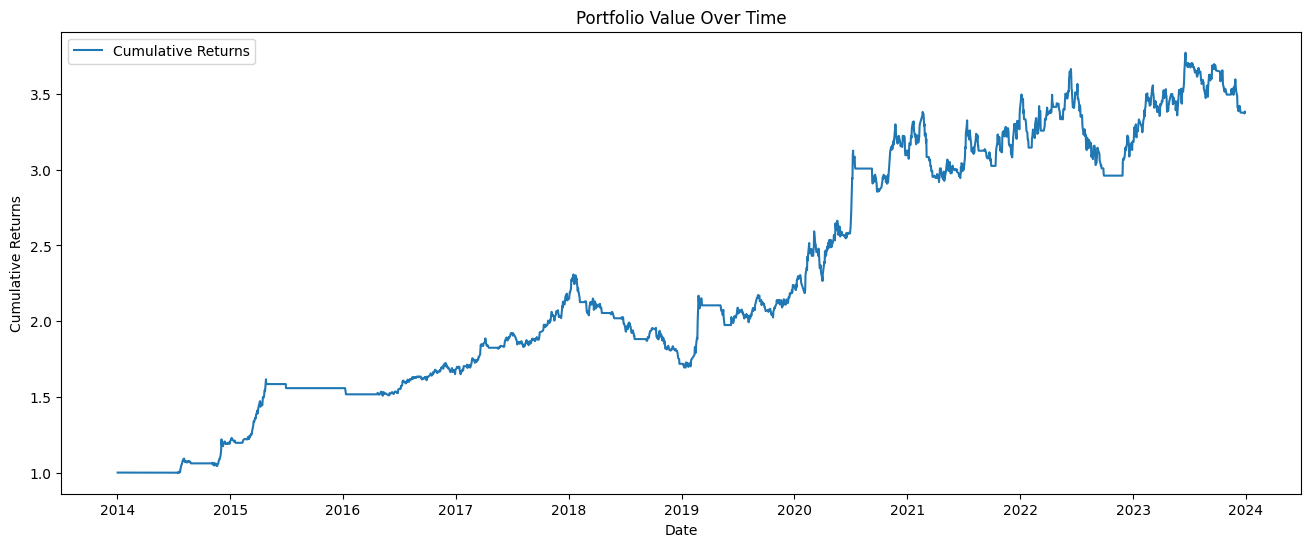

初始资金: 10000
最终资金: 33833.449999999975
年化收益率: 13.34%
最大回撤: -26.64%
未考虑无风险利率的夏普比率: 0.95
交易次数: 244


In [8]:
df = df_price_entry.copy()
count = 0
initial_capital = 10000
positions = 2 
slippage_and_fees = 0.00  # 滑点
stop_loss_threshold = 0.03  # 止损阈值
take_profit_threshold = 0.06  # 止盈阈值
drawdown_for_take_profit = 0.03  # 回撤开始止盈
portfolio_value_tracker = []

capital = initial_capital
cash = initial_capital  
etf_value = 0
holdings = {etf: 0 for etf in df.columns} 
peak = {etf: 0 for etf in df.columns}

# 突破60日均线 + 斜率
def check_buy_signals(etf, price_data_daily, current_date, start_date):
    if len(price_data_daily) < 60 or current_date < start_date + pd.Timedelta(days=60):
        return False
    ma50 = price_data_daily[-60:].mean()
    yesterday_close = price_data_daily[-2]
    today_close = price_data_daily[-1]
    slope_positive = np.polyfit(range(60), price_data_daily[-60:], 1)[0] > 0
    if yesterday_close < ma50 and today_close >= ma50 and slope_positive:
        return True
    
    # if yesterday_close < ma50 and today_close >= ma50:
    #     return True
    return False


def buy(etf, price, date):
    global capital, cash, etf_value, holdings,count
    if not np.isnan(price) and holdings[etf] == 0:
        num_held_etfs = sum(1 for h in holdings.values() if h > 0)
        if num_held_etfs < positions:
            # 仅使用现金计算可投资资金
            investable_cash = cash / (positions - num_held_etfs)
            etf_amount = int(investable_cash * (1 - slippage_and_fees) / price)// 100 * 100
            holdings[etf] = etf_amount
            cash -= etf_amount * price  
            peak[etf] = price
            print(f"{date}: 买入 {etf}, 价格 {price}, 数量 {etf_amount}")
            count+=1


def sell(etf, price, date):
    global capital, cash, etf_value, holdings,count
    if not np.isnan(price) and holdings[etf] > 0:
        proceeds = holdings[etf] * price * (1 - slippage_and_fees)
        cash += proceeds 
        etf_value -= holdings[etf] * price
        print(f"{date}: 卖出 {etf}, 价格 {price}, 数量 {holdings[etf]}")
        holdings[etf] = 0
        count+=1

def check_stop_conditions(etf, price):
    if holdings[etf] <= 0:
        return False
    if price < peak[etf] * (1 - stop_loss_threshold):
        return True
    if price > peak[etf] * (1 + take_profit_threshold):
        peak[etf] = price
    elif price < peak[etf] * (1 - drawdown_for_take_profit):
        return True
    return False

start_date = pd.to_datetime('2014-01-02')
# 主循环 循环df_price_entry和df_price_exit
trading_hours = ['10:30', '11:30', '14:00', '15:00']
for date, prices_daily in df.iterrows():
    date_str = date.strftime('%Y-%m-%d')
    for trading_hour in trading_hours:
        datetime_str = f"{date_str} {trading_hour}"
        datetime_index = pd.to_datetime(datetime_str)
        if datetime_index in df_price_exit.index:
            prices_hourly = df_price_exit.loc[datetime_index]

            # 循环 df_price_exit小时线数据找准时机出场
            for etf in prices_daily.index:
                if etf in prices_hourly and not np.isnan(prices_hourly[etf]):
                    price_hourly = prices_hourly[etf]
                    if check_stop_conditions(etf, price_hourly):
                        sell(etf, price_hourly, datetime_index)
    
    # 循环 df_price_entry 日线数据卖出
    for etf in prices_daily.index:
        price_data_daily = df[etf].loc[:date]
        if check_buy_signals(etf, price_data_daily, date, start_date):
            num_held_etfs = sum(1 for h in holdings.values() if h > 0)
            if num_held_etfs < positions:
                buy(etf, prices_daily[etf], date)
    etf_value = sum(holdings[etf] * prices_daily[etf] for etf in prices_daily.index if holdings[etf] > 0)
    capital = cash + etf_value
    portfolio_value_tracker.append(capital)

portfolio_values = np.array(portfolio_value_tracker)
returns = portfolio_values[1:] / portfolio_values[:-1] - 1
cumulative_returns = portfolio_values / initial_capital - 1

# 年化收益率
annualized_return = (portfolio_values[-1] / portfolio_values[0])**(250/len(portfolio_values))-1
rolling_max = np.maximum.accumulate(portfolio_values)
daily_drawdown = portfolio_values / rolling_max - 1
max_drawdown = np.min(daily_drawdown)

average_daily_return = np.mean(returns)
annualized_dev = np.std(returns) * np.sqrt(252)
sharp_ratio = annualized_return / annualized_dev

plt.figure(figsize=(16, 6))
plt.plot(df.index, portfolio_values/10000, label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

print(f"初始资金: {initial_capital}")
print(f"最终资金: {portfolio_values[-1]}")
print(f"年化收益率: {annualized_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"未考虑无风险利率的夏普比率: {sharp_ratio:.2f}")
print(f"交易次数: {count}")

2014-07-22 00:00:00: 买入 159928.XSHE, 价格 0.24, 数量 20800
2014-07-25 00:00:00: 买入 159930.XSHE, 价格 0.8140000000000001, 数量 6100
2014-10-17 10:30:00: 卖出 159930.XSHE, 价格 0.889, 数量 6100
2014-11-27 00:00:00: 买入 512010.XSHG, 价格 0.2442, 数量 22300
2014-12-18 15:00:00: 卖出 512010.XSHG, 价格 0.2512, 数量 22300
2014-12-22 10:30:00: 卖出 159928.XSHE, 价格 0.2788, 数量 20800
2014-12-22 00:00:00: 买入 159930.XSHE, 价格 1.095, 数量 5200
2014-12-23 10:30:00: 卖出 159930.XSHE, 价格 1.059, 数量 5200
2015-01-05 00:00:00: 买入 159928.XSHE, 价格 0.2998, 数量 18700
2015-01-05 00:00:00: 买入 159930.XSHE, 价格 1.185, 数量 4700
2015-01-07 11:30:00: 卖出 159930.XSHE, 价格 1.135, 数量 4700
2015-01-12 14:00:00: 卖出 159928.XSHE, 价格 0.2908, 数量 18700
2015-01-22 00:00:00: 买入 512010.XSHG, 价格 0.2665, 数量 20300
2015-02-06 14:00:00: 卖出 512010.XSHG, 价格 0.2558, 数量 20300
2015-03-02 00:00:00: 买入 159928.XSHE, 价格 0.3022, 数量 17500
2015-03-05 00:00:00: 买入 512010.XSHG, 价格 0.2738, 数量 19400
2015-03-09 10:30:00: 卖出 512010.XSHG, 价格 0.2655, 数量 19400
2015-03-13 00:00:00: 买入 512010.X

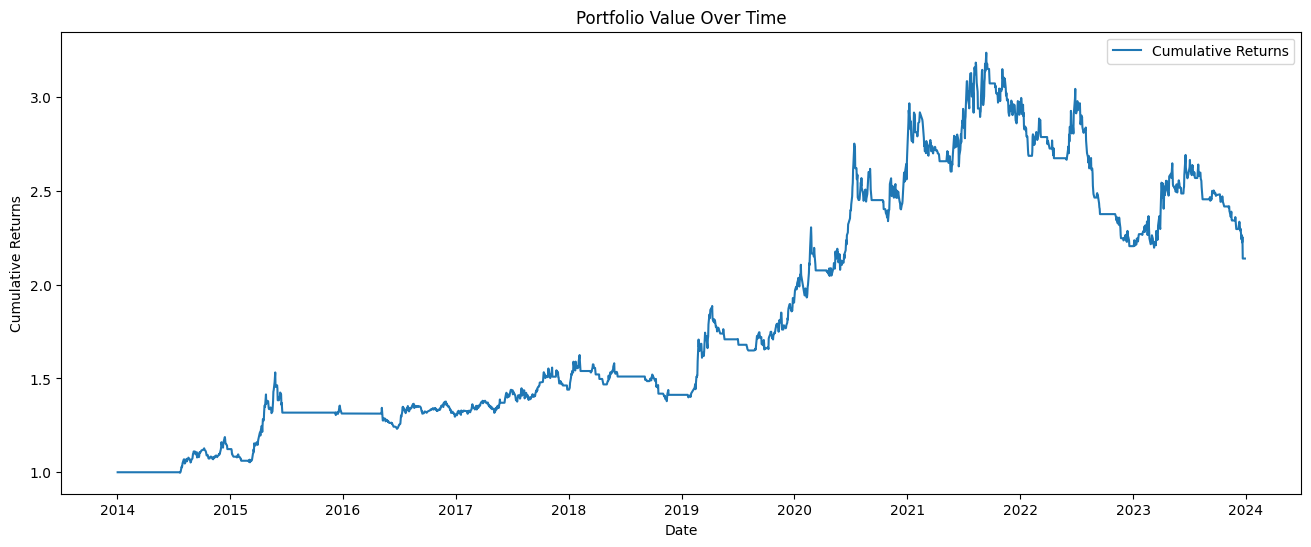

初始资金: 10000
最终资金: 21385.209999999985
年化收益率: 8.12%
最大回撤: -33.89%
夏普比率: 0.55
交易次数: 354


In [61]:
df = df_price_entry.copy()
count = 0
initial_capital = 10000
positions = 2  # 仓位数
slippage_and_fees = 0.00  # 滑点手续费
stop_loss_threshold = 0.03  # 止损阈值
take_profit_threshold = 0.06  # 止盈阈值
drawdown_for_take_profit = 0.03  # 回撤开始止盈
portfolio_value_tracker = []

capital = initial_capital
cash = initial_capital  
etf_value = 0
holdings = {etf: 0 for etf in df.columns} 
peak = {etf: 0 for etf in df.columns}


def check_buy_signals(etf, price_data_daily, current_date, start_date):
    if len(price_data_daily) < 60 or current_date < start_date + pd.Timedelta(days=60):
        return False
    slope_positive = np.polyfit(range(60), price_data_daily[-60:], 1)[0] > 0
    if price_data_daily[-1] > max(price_data_daily[-61:-1])  and slope_positive:
        return True
    return False

def buy(etf, price, date):
    global capital, cash, etf_value, holdings,count
    if not np.isnan(price) and holdings[etf] == 0:
        num_held_etfs = sum(1 for h in holdings.values() if h > 0)
        if num_held_etfs < positions:
            # 仅使用现金计算可投资资金
            investable_cash = cash / (positions - num_held_etfs)
            etf_amount = int(investable_cash * (1 - slippage_and_fees) / price)// 100 * 100
            holdings[etf] = etf_amount
            cash -= etf_amount * price  
            peak[etf] = price
            print(f"{date}: 买入 {etf}, 价格 {price}, 数量 {etf_amount}")
            count+=1


def sell(etf, price, date):
    global capital, cash, etf_value, holdings,count
    if not np.isnan(price) and holdings[etf] > 0:
        proceeds = holdings[etf] * price * (1 - slippage_and_fees)
        cash += proceeds 
        etf_value -= holdings[etf] * price
        print(f"{date}: 卖出 {etf}, 价格 {price}, 数量 {holdings[etf]}")
        holdings[etf] = 0
        count+=1

def check_stop_conditions(etf, price):
    if holdings[etf] <= 0:
        return False
    if price < peak[etf] * (1 - stop_loss_threshold):
        return True
    if price > peak[etf] * (1 + take_profit_threshold):
        peak[etf] = price
    elif price < peak[etf] * (1 - drawdown_for_take_profit):
        return True
    return False


trading_hours = ['10:30', '11:30', '14:00', '15:00']
for date, prices_daily in df.iterrows():
    date_str = date.strftime('%Y-%m-%d')
    for trading_hour in trading_hours:
        datetime_str = f"{date_str} {trading_hour}"
        datetime_index = pd.to_datetime(datetime_str)
        if datetime_index in df_price_exit.index:
            prices_hourly = df_price_exit.loc[datetime_index]

            for etf in prices_daily.index:
                if etf in prices_hourly and not np.isnan(prices_hourly[etf]):
                    price_hourly = prices_hourly[etf]
                    if check_stop_conditions(etf, price_hourly):
                        sell(etf, price_hourly, datetime_index)
    for etf in prices_daily.index:
        price_data_daily = df[etf].loc[:date]
        if check_buy_signals(etf, price_data_daily, date, start_date):
            num_held_etfs = sum(1 for h in holdings.values() if h > 0)
            if num_held_etfs < positions:
                buy(etf, prices_daily[etf], date)
    etf_value = sum(holdings[etf] * prices_daily[etf] for etf in prices_daily.index if holdings[etf] > 0)
    capital = cash + etf_value
    portfolio_value_tracker.append(capital)

portfolio_values = np.array(portfolio_value_tracker)
returns = portfolio_values[1:] / portfolio_values[:-1] - 1
cumulative_returns = portfolio_values / initial_capital - 1

# 年化收益率
annualized_return = (portfolio_values[-1] / portfolio_values[0])**(250/len(portfolio_values))-1
rolling_max = np.maximum.accumulate(portfolio_values)
daily_drawdown = portfolio_values / rolling_max - 1
max_drawdown = np.min(daily_drawdown)

average_daily_return = np.mean(returns)
std_dev = np.std(returns)
sharp_ratio = (average_daily_return / std_dev) * np.sqrt(252)

plt.figure(figsize=(16, 6))
plt.plot(df.index, portfolio_values/10000, label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

print(f"初始资金: {initial_capital}")
print(f"最终资金: {portfolio_values[-1]}")
print(f"年化收益率: {annualized_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"夏普比率: {sharp_ratio:.2f}")
print(f"交易次数: {count}")